# Has Fandango Stopped Inflating Movie Ratings?

Journalist Walt Hickey found in 2015 that movie ticket and rating site Fandango has been inflating their ratings. It was seen that every average rating for a movie was being rounded up to the nearest .5 stars, so a movie rated 4.1 would be upped to a 4.5. In some cases, these inflations were even more than .5. The site claims this to be accidental, however considering the site is used as a vender to sell tickets, it could possibly be considered false advertising.

In this project, we will compare Hickey's data with new data from Fandango, from 2016-17. Thwe goal is to see if that inflation has at all changed. We start by reading in the datasets.

In [1]:
import pandas as pd
fand_scores = pd.read_csv('fandango_score_comparison.csv')
movie_rats = pd.read_csv('movie_ratings_16_17.csv')
print(fand_scores.head(2))
print(movie_rats.head(2))

                             FILM  RottenTomatoes  RottenTomatoes_User  \
0  Avengers: Age of Ultron (2015)              74                   86   
1               Cinderella (2015)              85                   80   

   Metacritic  Metacritic_User  IMDB  Fandango_Stars  Fandango_Ratingvalue  \
0          66              7.1   7.8             5.0                   4.5   
1          67              7.5   7.1             5.0                   4.5   

   RT_norm  RT_user_norm         ...           IMDB_norm  RT_norm_round  \
0     3.70           4.3         ...                3.90            3.5   
1     4.25           4.0         ...                3.55            4.5   

   RT_user_norm_round  Metacritic_norm_round  Metacritic_user_norm_round  \
0                 4.5                    3.5                         3.5   
1                 4.0                    3.5                         4.0   

   IMDB_norm_round  Metacritic_user_vote_count  IMDB_user_vote_count  \
0              

We can get a vibe for what sort of data is in each dataset. Now we can isolate just the columns we're interested in their fandango scores, into the Hickey dataset and the new data after the article was released.

In [5]:
hickey = fand_scores[['FILM','Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
after = movie_rats[['movie', 'year','fandango']].copy()

We can see in the README documentation for the two libraries that the Hickey dataset uses all movies within the population that were popular enough to receive enough ratings and had ticket sales during 2015, while the after dataset used an assumedly random sample of over 200 movies that also have a threshold of popularity. 

So the sample isn't fully random, as it assumes a certain degree of popularity, but if we shift our population from "all movies" to "popular movies", the datasets seem properly representative.

Our goal is thus to see if *From 2015 to 2016, has Fandango ceased inflating the ratings of **popular** movies?*

### Isolatng the Data

So what qualifies a popular movie? In Hickey's dataset, only movies with over 30 ratings are considered popular. While this is an arbitrary benchmark, it is a good definition to have consistency. The new dataset for 16-17 doesn't include a column for number of ratings.

We can check the number of ratings by just checking a small sample:

In [6]:
after.sample(10, random_state = 0)

,movie,year,fandango
197,The Take (Bastille Day),2016,4.0
37,Come and Find Me,2016,4.0
89,Kickboxer,2016,4.0
176,The Founder,2016,4.0
170,The Darkness,2016,2.5
75,Ice Age: Collision Course,2016,4.0
96,Lion,2016,4.0
137,Ride Along 2,2016,4.0
5,A Monster Calls,2016,4.0
83,Jane Got a Gun,2016,3.5


By looking manually at these ten movies we can see... Not much! As Fandango has discontinued their rating system, replacing it with Rotten Tomatoes. That said, 9/10 of these movies, all except "Come and Find Me" have over 30 ratings on Rotten Tomatoes. 90% is a good indicator that this properly represents popular movies from the time. 

In [7]:
print(hickey[hickey['Fandango_votes'] < 30])

Empty DataFrame
Columns: [FILM, Fandango_Stars, Fandango_Ratingvalue, Fandango_votes, Fandango_Difference]
Index: []


We can see here that Hickey's qualification of at least thirty reviews is indeed applied to his dataset. 

As we are specifcally looking from 2015 to 2016, we need to isolate all movies in the Hickey dataset specifically released in 2016, and all from the After dataset released during 2016. For the Hickey dataset, the year is within the 'FILM' column, stored between parenthesis. we can isolate the year using a regular expression.

In [20]:
hickey_years = hickey['FILM'].str.extract(r'\((201[0-9])\)', expand = False)
print(hickey_years.value_counts())

2015    129
2014     17
Name: FILM, dtype: int64


We can see we have 129 rows from 2015, and 17 rows in 2014. Let's create a new filtered dataset only with 2015.

In [26]:
hickey_2015 = hickey[hickey['FILM'].str.contains(r'\(2015\)')]
print(hickey_2015.count())

FILM                    129
Fandango_Stars          129
Fandango_Ratingvalue    129
Fandango_votes          129
Fandango_Difference     129
dtype: int64


Great! We now have a complete dataset with 129 rows. Let's do the same to the after dataset.

In [27]:
after['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

We must remove the 23 values from 2017.

In [29]:
after_2016 = after[after['year'] == 2016]
after_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Disribution Shapes Year to Year

Now that we've isolated the data, we can start to get to the meat of the analysis. Let's compare those Fandango ratings! To start, we create a kernel density plot.

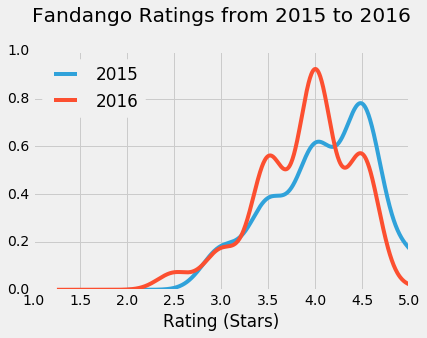

In [37]:
from numpy import arange
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
hickey_2015['Fandango_Stars'].plot.kde(label = '2015', legend = True)
after_2016['fandango'].plot.kde(label = '2016', legend = True)
plt.title('Fandango Ratings from 2015 to 2016', y = 1.1)
plt.xlabel('Rating (Stars)')
plt.ylabel('')
plt.xlim(1,5) # because ratings start at 0 and end at 5, but no movies receive under a 2, let alone 1..
plt.xticks(arange(1,5.1,.5))
plt.show()

We can see that the 2015 ratings are significantly higher than the 2016 ratings. Both skew to the left, as movies tend to get between 3 and 5 stars, but while the mode for 2016 appears to be 4.5, in 2015 it is 4. This could indicate that the score inflation has indeed ceased.

Let's look at the actual data, and compare the proportional frequencies of each rating from year to year.

In [51]:
print('2015')
print(hickey_2015['Fandango_Stars'].value_counts(normalize = True).sort_index(ascending = False).round(4)*100)
print('\n' + '2016')
print(after_2016['fandango'].value_counts(normalize = True).sort_index(ascending = False).round(4)*100)

2015
5.0     6.98
4.5    37.98
4.0    28.68
3.5    17.83
3.0     8.53
Name: Fandango_Stars, dtype: float64

2016
5.0     0.52
4.5    24.61
4.0    40.31
3.5    24.08
3.0     7.33
2.5     3.14
Name: fandango, dtype: float64


We can still see clearly a difference between the two systems. In 2015, it was impossible for a popular movie to even get 2.5 stars! 

45% of popular films had 4.5 stars or higher, compared to 25% in 2016. 

25% of popular films in 2015 were below 4 stars, while in 2016 that number increased to almost 35%.

Let's confirm our findings with summary statistics.

In [59]:
summary_2015 = [hickey_2015['Fandango_Stars'].mean().round(3), hickey_2015['Fandango_Stars'].median(),hickey_2015['Fandango_Stars'].mode()[0]]
summary_2016 = [after_2016['fandango'].mean().round(3),after_2016['fandango'].median(),after_2016['fandango'].mode()[0]]#[0] for formatting
summary = pd.DataFrame()
summary['2015'] = summary_2015
summary['2016'] = summary_2016
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085,3.887
median,4.000,4.000
mode,4.500,4.000


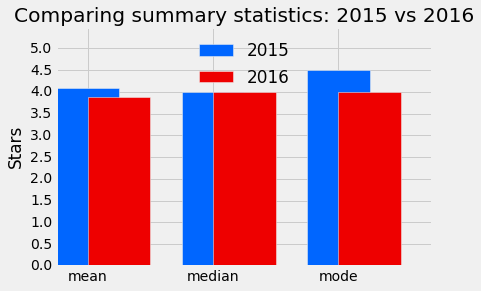

In [74]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', label = '2015')
summary['2016'].plot.bar(color = '#EE0000', label = '2016',align = 'edge', rot =0)

plt.title('Comparing summary statistics: 2015 vs 2016')
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

## Conclusion

Once again, we see there is a difference between the two years. The mean Fandango rating has decreased as well as the mode. It isn't an astronomical difference, as indicated by the median remaining the same, but considering the scale only has 11 possible values, where 2 stars or below, five of the values, never occur, this is a significant change.